In [1]:
! pip install cython opencv-python pydensecrf

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from tensorflow.keras.optimizers import Adam

image_size = (512, 512) #(512,512) (720, 1280)
batch_size = 2
train_epochs = 200

better_model = True
load_pretrained_weights = False
multi_gpu = True

losses = sparse_crossentropy_ignoring_last_label
metrics = { 'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label] }

backbone = 'xception' #mobilenetv2, xception

NET = 'deeplab_' + backbone
PATH = '/tf/data/datasets/dog/'

classes = {
    0: 'background', 
    1:  'dog',
    255: 'void',
}
n_classes = len(classes) - 1

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', batch_size)


SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(batch_size)

Num workers: 6
Backbone: xception
Path to dataset: /tf/data/datasets/dog/
N classes: 2
Image size: (512, 512)
Batch size: 2


## DeepLab V3+ And a SubPixel Upsampling Layer (better model) or Original

In [13]:
if better_model:
    model = SegClass.create_seg_model(net = 'subpixel',
                                      n_classes = n_classes,
                                      load_weights = load_pretrained_weights, 
                                      multi_gpu = multi_gpu,
                                      backbone = backbone)
else:
    model = SegClass.create_seg_model(net = 'original',
                                      n_classes = n_classes,
                                      load_weights = load_pretrained_weights, 
                                      multi_gpu = multi_gpu,
                                      backbone = backbone)
    
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)

if load_pretrained_weights:
    print('Weights path:', SegClass.modelpath)

### Train with generator

In [14]:
train_generator = SegClass.create_generators(blur=5,
                                             crop_shape=None,
                                             mode='train',
                                             n_classes=n_classes,
                                             horizontal_flip=True,
                                             vertical_flip=False,
                                             brightness=0.3, 
                                             rotation=False,
                                             zoom=0.1,
                                             seed=7,
                                             do_ahisteq=False)
valid_generator = SegClass.create_generators(blur=0,
                                             crop_shape=None,
                                             mode='validation', 
                                             n_classes=n_classes,
                                             horizontal_flip=True,
                                             vertical_flip=False, 
                                             brightness=.1,
                                             rotation=False,
                                             zoom=.05, 
                                             seed=7,
                                             do_ahisteq=False)

print('Images for Training: %s' % (len(train_generator.image_path_list)))
print('Images for Validation: %s' % (len(valid_generator.image_path_list)))

Images for Training: 45
Images for Validation: 5


In [15]:
monitor = 'Jaccard'
mode = 'max'

# fine-tune model (train only last conv layers)
if load_pretrained_weights:
    flag = 0
    for k, l in enumerate(model.layers):
        l.trainable = False
        if l.name == 'concat_projection':
            flag = 1
        if flag:
            l.trainable = True
        
def build_callbacks(tf_board = False):
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        tensorboard = TensorBoard(log_dir='./logs/'+SegClass.net,
                                  histogram_freq=0,
                                  write_graph=False,
                                  write_images = False)
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        checkpointer = ModelCheckpoint(filepath = SegClass.modelpath,
                                       verbose=1,
                                       save_best_only=False,
                                       save_weights_only=True,
                                       monitor = 'val_{}'.format(monitor),
                                       mode = mode,
                                       save_freq='epoch')
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)
        
SegClass.set_num_epochs(train_epochs)
history = SegClass.train_generator(model, train_generator, valid_generator, callbacks, mp=False)

Epoch 1/200
 2/22 [=>............................] - ETA: 17s - loss: 0.7274 - Jaccard: 0.4557 - sparse_accuracy_ignoring_last_label: 0.9114
Epoch 00001: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 32s 1s/step - loss: 0.5135 - Jaccard: 0.5874 - sparse_accuracy_ignoring_last_label: 0.8984 - val_loss: 0.7274 - val_Jaccard: 0.4557 - val_sparse_accuracy_ignoring_last_label: 0.9114
Epoch 2/200
 2/22 [=>............................] - ETA: 17s - loss: 0.6953 - Jaccard: 0.0521 - sparse_accuracy_ignoring_last_label: 0.1041
Epoch 00002: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.4274 - Jaccard: 0.5921 - sparse_accuracy_ignoring_last_label: 0.8235 - val_loss: 0.6953 - val_Jaccard: 0.0521 - val_sparse_accuracy_ignoring_last_label: 0.1041
Epoch 3/200
 2/22 [=>............................] - ETA: 17s - loss: 0.6939 - Jaccard: 0.0548 - sparse_accuracy_ignoring_last_label: 0.1096
Epoch 00003: sa

22/22 [==============================] - 28s 1s/step - loss: 0.3799 - Jaccard: 0.5788 - sparse_accuracy_ignoring_last_label: 0.8555 - val_loss: 0.7400 - val_Jaccard: 0.4584 - val_sparse_accuracy_ignoring_last_label: 0.9169
Epoch 16/200
 2/22 [=>............................] - ETA: 17s - loss: 0.7874 - Jaccard: 0.4674 - sparse_accuracy_ignoring_last_label: 0.9347
Epoch 00016: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3506 - Jaccard: 0.5336 - sparse_accuracy_ignoring_last_label: 0.8353 - val_loss: 0.7874 - val_Jaccard: 0.4674 - val_sparse_accuracy_ignoring_last_label: 0.9347
Epoch 17/200
 2/22 [=>............................] - ETA: 17s - loss: 0.7017 - Jaccard: 0.4763 - sparse_accuracy_ignoring_last_label: 0.9526
Epoch 00017: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3782 - Jaccard: 0.6295 - sparse_accuracy_ignoring_last_label: 0.8583 - val_loss: 0.7017 - v

22/22 [==============================] - 28s 1s/step - loss: 0.3902 - Jaccard: 0.5860 - sparse_accuracy_ignoring_last_label: 0.8442 - val_loss: 0.3798 - val_Jaccard: 0.6441 - val_sparse_accuracy_ignoring_last_label: 0.8818
Epoch 45/200
 2/22 [=>............................] - ETA: 17s - loss: 0.7655 - Jaccard: 0.5655 - sparse_accuracy_ignoring_last_label: 0.8478
Epoch 00045: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3289 - Jaccard: 0.5809 - sparse_accuracy_ignoring_last_label: 0.8473 - val_loss: 0.7655 - val_Jaccard: 0.5655 - val_sparse_accuracy_ignoring_last_label: 0.8478
Epoch 46/200
 2/22 [=>............................] - ETA: 17s - loss: 0.4207 - Jaccard: 0.6236 - sparse_accuracy_ignoring_last_label: 0.8763
Epoch 00046: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3740 - Jaccard: 0.5611 - sparse_accuracy_ignoring_last_label: 0.8404 - val_loss: 0.4207 - v

22/22 [==============================] - 28s 1s/step - loss: 0.3374 - Jaccard: 0.5535 - sparse_accuracy_ignoring_last_label: 0.8479 - val_loss: 0.3035 - val_Jaccard: 0.5835 - val_sparse_accuracy_ignoring_last_label: 0.8851
Epoch 74/200
 2/22 [=>............................] - ETA: 17s - loss: 0.6712 - Jaccard: 0.5602 - sparse_accuracy_ignoring_last_label: 0.8316
Epoch 00074: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 29s 1s/step - loss: 0.3946 - Jaccard: 0.6376 - sparse_accuracy_ignoring_last_label: 0.8604 - val_loss: 0.6712 - val_Jaccard: 0.5602 - val_sparse_accuracy_ignoring_last_label: 0.8316
Epoch 75/200
 2/22 [=>............................] - ETA: 17s - loss: 0.3329 - Jaccard: 0.6467 - sparse_accuracy_ignoring_last_label: 0.8682
Epoch 00075: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3298 - Jaccard: 0.5783 - sparse_accuracy_ignoring_last_label: 0.8545 - val_loss: 0.3329 - v

22/22 [==============================] - 28s 1s/step - loss: 0.3453 - Jaccard: 0.5281 - sparse_accuracy_ignoring_last_label: 0.8352 - val_loss: 0.4866 - val_Jaccard: 0.6212 - val_sparse_accuracy_ignoring_last_label: 0.8852
Epoch 103/200
 2/22 [=>............................] - ETA: 17s - loss: 0.4876 - Jaccard: 0.5975 - sparse_accuracy_ignoring_last_label: 0.8695
Epoch 00103: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3384 - Jaccard: 0.6206 - sparse_accuracy_ignoring_last_label: 0.8650 - val_loss: 0.4876 - val_Jaccard: 0.5975 - val_sparse_accuracy_ignoring_last_label: 0.8695
Epoch 104/200
 2/22 [=>............................] - ETA: 17s - loss: 0.4918 - Jaccard: 0.5686 - sparse_accuracy_ignoring_last_label: 0.8668
Epoch 00104: saving model to weights/xception_subpixel.h5
22/22 [==============================] - 28s 1s/step - loss: 0.3574 - Jaccard: 0.5479 - sparse_accuracy_ignoring_last_label: 0.8392 - val_loss: 0.4918 -

### Compare Models

In [21]:
# Load original deeplab and subpixel-deeplab
#model1 = SegClass.create_seg_model(net='original',n_classes=n_classes, load_weights=False, multi_gpu=multi_gpu, backbone=backbone)
#model1.load_weights('weights/mobilenetv2_original.h5')
model1 = SegClass.create_seg_model(net='subpixel',n_classes=n_classes, load_weights=False, multi_gpu=multi_gpu, backbone=backbone)
model1.load_weights('weights/xception_subpixel.h5')

In [6]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

pixels background 193533
pixels not background 68611
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


Text(0.5, 1.0, 'Subpixel DeepLab + CRF\nmIOU: 0.44')

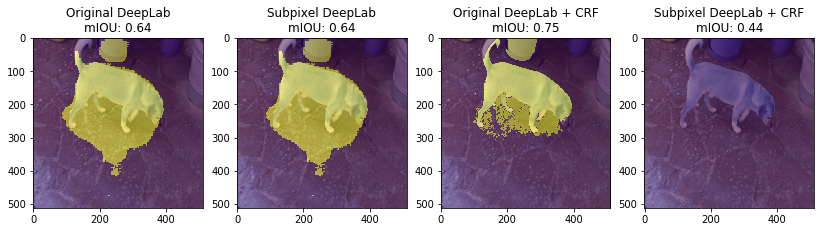

In [22]:
i = np.random.randint(0, len(valid_generator))
x,y,s = valid_generator.__getitem__(i)

preds1 = np.argmax(model1.predict(x), -1)[0].reshape(image_size)
#preds2 = np.argmax(model2.predict(x), -1)[0].reshape(image_size)

preds2 = preds1

print('pixels background %s' % (preds2.size - np.count_nonzero(preds2)))
print('pixels not background %s' % (np.count_nonzero(preds2)))

im = x[0].astype('uint8')
gt = y[0].reshape(image_size).astype('int32')

plt.figure(figsize=(14,10))

plt.subplot(141)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds1, alpha=.5)
plt.title('Original DeepLab\nmIOU: '+str(mIOU(gt, preds1)))

plt.subplot(142)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds2, alpha=.5)
plt.title('Subpixel DeepLab\nmIOU: '+str(mIOU(gt, preds2)))

plt.subplot(143)
MAP = do_crf(im, preds1, zero_unsure=False, n_labels=n_classes)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Original DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))

plt.subplot(144)
MAP = do_crf(im, preds2, zero_unsure=True, n_labels=n_classes)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Subpixel DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))

In [24]:
def calculate_iou(model, nb_classes = 21):
    SegClass.set_batch_size(1)
    valid_generator = SegClass.create_generators(crop_shape = None, mode = 'validation', n_classes = nb_classes, 
                                                 horizontal_flip = False, vertical_flip = False,
                                                 brightness=0, rotation=False,
                                                 zoom=0, seed = 7, do_ahisteq = False)
    label = np.zeros((len(valid_generator),np.prod(image_size)), dtype='float32')
    X = np.zeros((len(valid_generator), image_size[0], image_size[1], 3), dtype='float32')
    for n in range(len(valid_generator)):
        x,y,_ = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        X[n,:,:,:] = x
    preds = model.predict(X, batch_size=1)
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    total = 0
    mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)
    flat_pred = np.ravel(mask).astype('int')
    flat_label = np.ravel(label).astype('int')
    for p, l in zip(flat_pred, flat_label):
        if l == nb_classes:
            continue
        if l < nb_classes and p < nb_classes:
            conf_m[l-1, p-1] += 1
        else:
            print('Invalid entry encountered, skipping! Label: ', l,
                    ' Prediction: ', p, ' Img_num: ', img_num)
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    meanIOU = np.mean(IOU)
    return conf_m
conf_1 = calculate_iou(model1, nb_classes = n_classes)
conf_2 = calculate_iou(model2, nb_classes = n_classes)

Text(0.5, 1, 'Subpixel DeepLab\nMean IOU: 0.5')

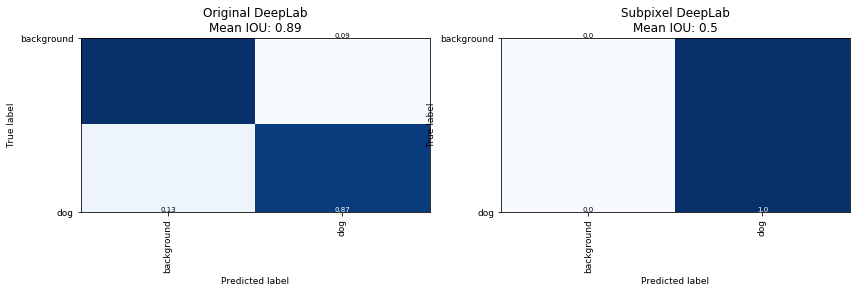

In [25]:
classes = [c for c in classes.values()][:-1]
plt.figure(figsize=(12,8))
plt.subplot(121)
cm1=plot_confusion_matrix(conf_1, classes, normalize=True)
plt.title('Original DeepLab\nMean IOU: '+ str(np.round(np.diag(cm1).mean(), 2)))
plt.subplot(122)
cm2=plot_confusion_matrix(conf_2, classes, normalize=True)
plt.title('Subpixel DeepLab\nMean IOU: '+ str(np.round(np.diag(cm2).mean(), 2)))